In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib
import matplotlib.font_manager as fm
import itertools
import statsmodels.api as sm 
import random
import datetime
matplotlib.rcParams['text.color'] = 'k'
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'retina'


card 와 Index 데이터를 활용하여 유망 산업, 유망 직군을 찾아보려 합니다. 역시 fbprophet을 이용해서  간단히 분석해보겠습니다. 

In [2]:
! pip install pystan

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [3]:
Card =pd.read_csv("./Data_KT/card.csv")
Card


,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
0,20200104,1174066000,성내3동,7041,약국,463,5843230
1,20200104,1174066000,성내3동,7022,치과의원,33,7835550
2,20200104,1174066000,성내3동,7021,한의원,53,4589800
3,20200104,1174066000,성내3동,7020,의원,339,9267240
4,20200104,1174066000,성내3동,6110,자동차정비,19,4441000
...,...,...,...,...,...,...,...
3777642,20200614,1121586000,구의2동,4004,대형할인점,136,1195640
3777643,20200614,1121584700,자양4동,9010,인테 리어,2,13100
3777644,20200614,1162052500,보라매동,6140,주 차 장,2,14500
3777645,20200614,1135056000,월계1동,9998,기타전문점,1,38000


철물과 천막 데이터(오류)를 제거하고 salamt의 타입을 int로 바꾸어줍니다.
mrhst induty cl nm을 기준으로 표를 재정렬해줍니다. 

특별히 약국 데이터를 활용해 ARIMA 분석을 진행해보겠습니다. cgi가 거의 변함이 없으므로 약국의 성장은 기대하기 힘들 것 같습니다. 


In [4]:
idx_todelete = Card.loc[Card['salamt']=='천막'].index
idx_todelete2 = Card.loc[Card['salamt']=='철물'].index
Card = Card.drop(idx_todelete)
Card2 = Card.drop(idx_todelete2)
Card2['salamt_int'] = Card2['salamt'].astype(int)
Card2

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt,salamt_int
0,20200104,1174066000,성내3동,7041,약국,463,5843230,5843230
1,20200104,1174066000,성내3동,7022,치과의원,33,7835550,7835550
2,20200104,1174066000,성내3동,7021,한의원,53,4589800,4589800
3,20200104,1174066000,성내3동,7020,의원,339,9267240,9267240
4,20200104,1174066000,성내3동,6110,자동차정비,19,4441000,4441000
...,...,...,...,...,...,...,...,...
3777642,20200614,1121586000,구의2동,4004,대형할인점,136,1195640,1195640
3777643,20200614,1121584700,자양4동,9010,인테 리어,2,13100,13100
3777644,20200614,1162052500,보라매동,6140,주 차 장,2,14500,14500
3777645,20200614,1135056000,월계1동,9998,기타전문점,1,38000,38000


In [5]:

a = Card2.set_index('mrhst_induty_cl_nm')
a

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,selng_cascnt,salamt,salamt_int
mrhst_induty_cl_nm,,,,,,,
약국,20200104,1174066000,성내3동,7041,463,5843230,5843230
치과의원,20200104,1174066000,성내3동,7022,33,7835550,7835550
한의원,20200104,1174066000,성내3동,7021,53,4589800,4589800
의원,20200104,1174066000,성내3동,7020,339,9267240,9267240
자동차정비,20200104,1174066000,성내3동,6110,19,4441000,4441000
...,...,...,...,...,...,...,...
대형할인점,20200614,1121586000,구의2동,4004,136,1195640,1195640
인테 리어,20200614,1121584700,자양4동,9010,2,13100,13100
주 차 장,20200614,1162052500,보라매동,6140,2,14500,14500


In [6]:
df = pd.DataFrame({'old_date': [20200104, 20200105, 20200106, 20200107, 20200108, 20200109,
       20200110, 20200111, 20200112, 20200113, 20200114, 20200115,
       20200116, 20200117, 20200118, 20200119, 20200120, 20200121,
       20200122, 20200123, 20200124, 20200125, 20200126, 20200127,
       20200128, 20200129, 20200130, 20200131, 20200201, 20200202,
       20200203, 20200205, 20200206, 20200214, 20200215, 20200216,
       20200217, 20200218, 20200219, 20200220, 20200221, 20200222,
       20200223, 20200224, 20200225, 20200226, 20200227, 20200228,
       20200229, 20200301, 20200302, 20200303, 20200304, 20200305,
       20200306, 20200307, 20200308, 20200309, 20200310, 20200311,
       20200312, 20200313, 20200314, 20200315, 20200316, 20200317,
       20200318, 20200319, 20200320, 20200321, 20200322, 20200323,
       20200324, 20200325, 20200326, 20200327, 20200328, 20200329,
       20200330, 20200331, 20200401, 20200402, 20200403, 20200404,
       20200405, 20200406, 20200407, 20200408, 20200409, 20200410,
       20200411, 20200412, 20200413, 20200414, 20200415, 20200416,
       20200417, 20200418, 20200419, 20200420, 20200421, 20200422,
       20200423, 20200424, 20200425, 20200426, 20200427, 20200428,
       20200429, 20200430, 20200501, 20200502, 20200503, 20200504,
       20200505, 20200506, 20200507, 20200508, 20200509, 20200510,
       20200511, 20200512, 20200513, 20200514, 20200515, 20200516,
       20200517, 20200518, 20200519, 20200520, 20200521, 20200522,
       20200523, 20200524, 20200525, 20200526, 20200527, 20200528,
       20200529, 20200530, 20200531, 20200601, 20200602, 20200603,
       20200604, 20200605, 20200606, 20200607, 20200608, 20200609,
       20200610, 20200611, 20200612, 20200613, 20200614] })

df['new_date'] = pd.to_datetime(df['old_date'].astype(str), format='%Y%m%d')
df

,old_date,new_date
0,20200104,2020-01-04
1,20200105,2020-01-05
2,20200106,2020-01-06
3,20200107,2020-01-07
4,20200108,2020-01-08
...,...,...
150,20200610,2020-06-10
151,20200611,2020-06-11
152,20200612,2020-06-12
153,20200613,2020-06-13


In [7]:
! pip install Prophet

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [8]:

A = a.loc[a.index == '약국']
A

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,selng_cascnt,salamt,salamt_int
mrhst_induty_cl_nm,,,,,,,
약국,20200104,1174066000,성내3동,7041,463,5843230,5843230
약국,20200104,1174065000,성내2동,7041,239,2961460,2961460
약국,20200104,1174064000,성내1동,7041,193,2390510,2390510
약국,20200104,1174062000,천호3동,7041,325,4216630,4216630
약국,20200104,1174061000,천호2동,7041,642,9533200,9533200
...,...,...,...,...,...,...,...
약국,20200614,1135070000,상계8동,7041,191,2638740,2638740
약국,20200614,1150064000,방화2동,7041,240,3481850,3481850
약국,20200614,1126054000,면목4동,7041,70,775800,775800


In [9]:
#약국 datetime으로 바꿔주기
idx_med = pd.to_datetime(A['receipt_dttm'],format='%Y%m%d')
idx_med

mrhst_induty_cl_nm
약국   2020-01-04
약국   2020-01-04
약국   2020-01-04
약국   2020-01-04
약국   2020-01-04
        ...    
약국   2020-06-14
약국   2020-06-14
약국   2020-06-14
약국   2020-06-14
약국   2020-06-14
Name: receipt_dttm, Length: 62135, dtype: datetime64[ns]

In [10]:
lst_med = list(A['salamt_int'])
ts_med = Series(lst_med,idx_med)
y_med = ts_med.resample('D').sum()
y_med

y2_med= ts_med.resample('W').mean()


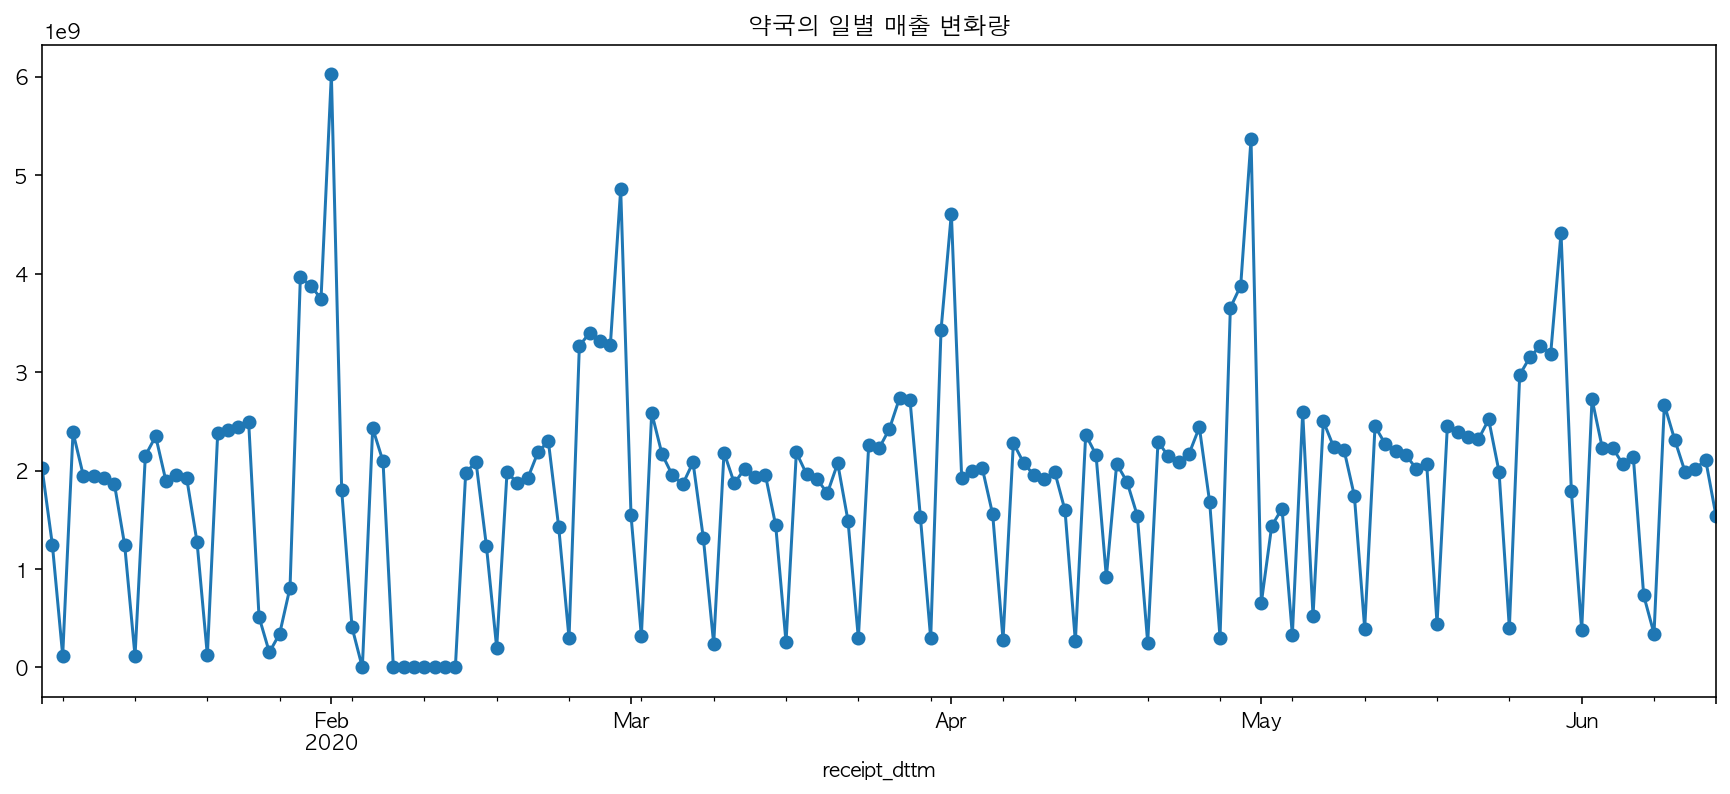

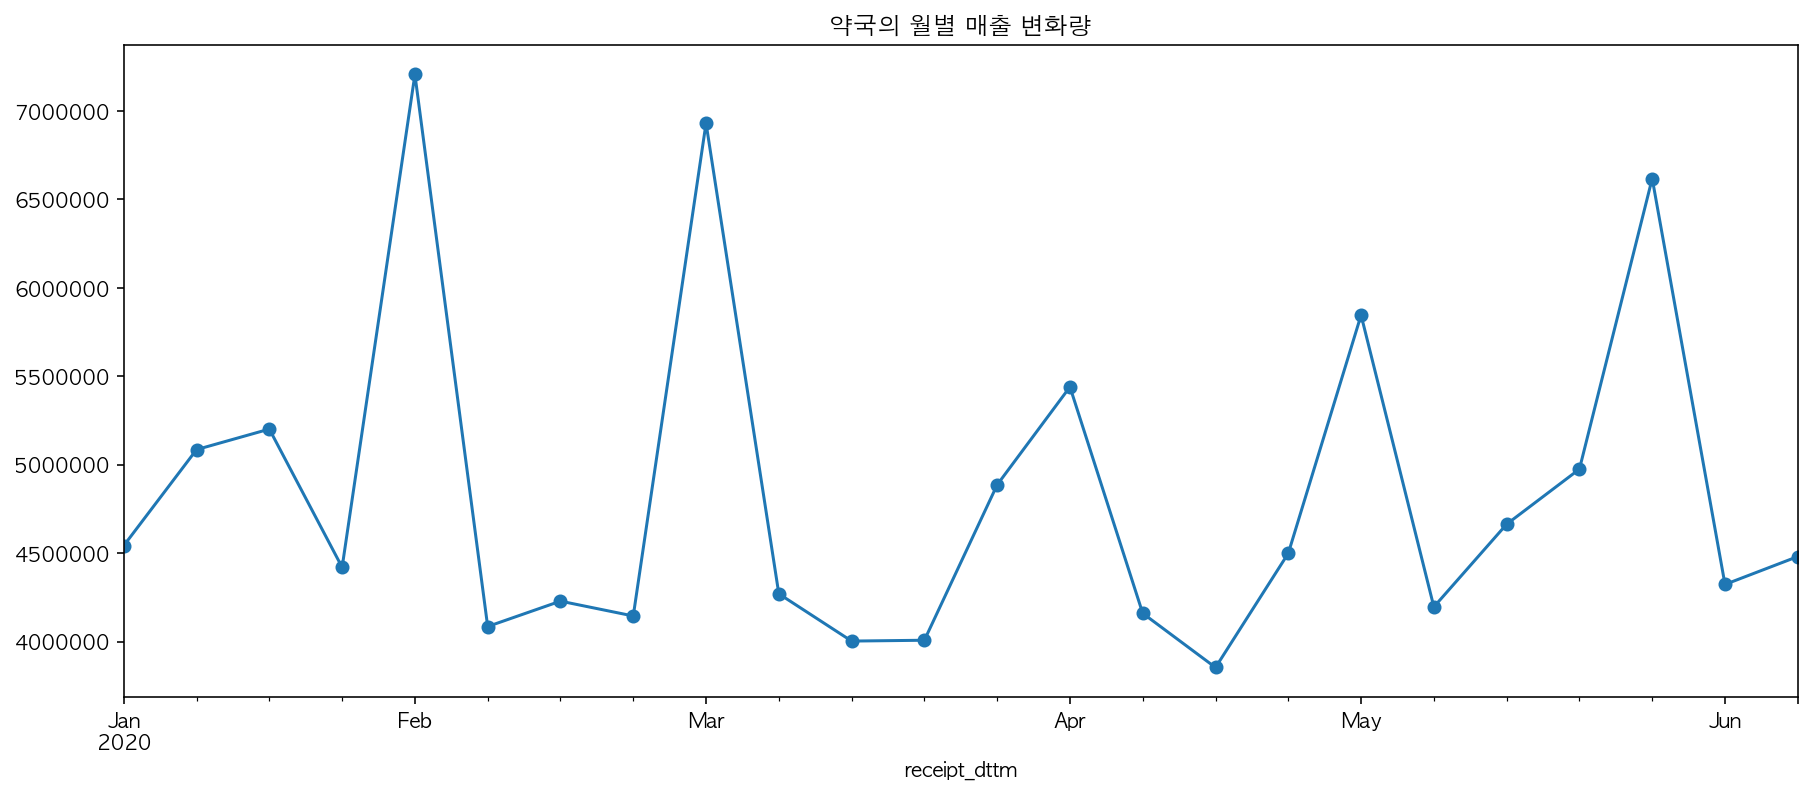

In [11]:
y_med.plot(figsize =(15,6), marker='o')
plt.title('약국의 일별 매출 변화량')
plt.show()


y2_med.plot(figsize=(15,6), marker='o')
plt.title('약국의 월별 매출 변화량')
plt.show()

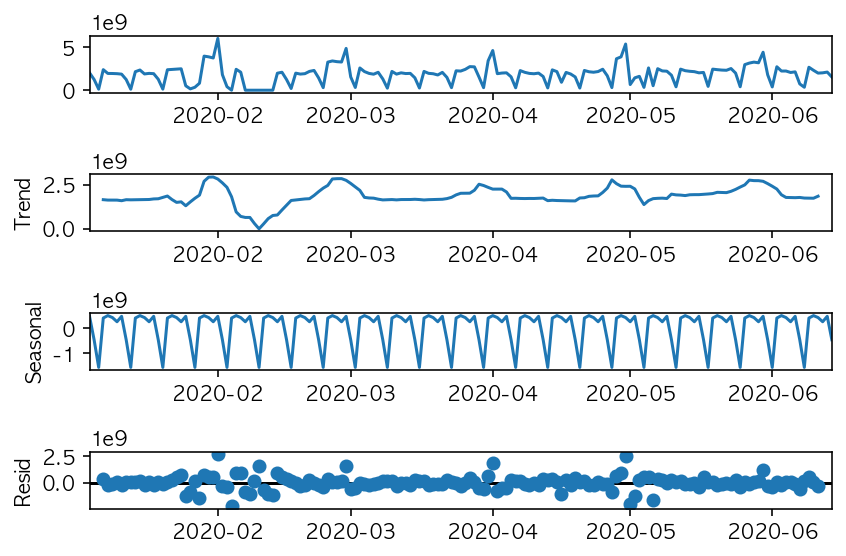

In [12]:
decomposition = sm.tsa.seasonal_decompose(y_med, model='additive')
fig = decomposition.plot()
plt.figsize = (20, 10)
plt.show()


In [13]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [14]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_med,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:26670.293589861794
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6841.908524073793


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1.1464572186337454e+16
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6201.619240089816
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6838.5346389498745
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6739.636487282132
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6269.555898037817
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6194.512610445878
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:7298.740342297591
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6747.767958568134
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6749.139373211548
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6147.048656503798
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6829.584011359702
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6724.990207513454
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6257.818071209125
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:6146.186702796482
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:6450390578239172.0


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:6676.527193806907


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:nan
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:6179.390004532079
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:6720.580365241854
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:6678.379620299622
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:6256.553181604581
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:6158.324819785627
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:7124.992334826665
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:6589.216913632594
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:6739.309170478593
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:6128.738904976011
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:6676.342775392917
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:6589.792906138186
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:6247.177081450289
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:6127.433782027044
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:7245.567428332395
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:6712.420054221564
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:6801.724099756515
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:6197.799004297141
ARIMA(1, 0, 0)x(1, 0, 0,

In [15]:
mod = sm.tsa.statespace.SARIMAX(y_med,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3819      0.128      2.975      0.003       0.130       0.634
ma.L1         -0.9492      0.048    -19.844      0.000      -1.043      -0.855
ar.S.L12      -0.5980      0.155     -3.858      0.000      -0.902      -0.294
sigma2      3.727e+18        nan        nan        nan         nan         nan


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


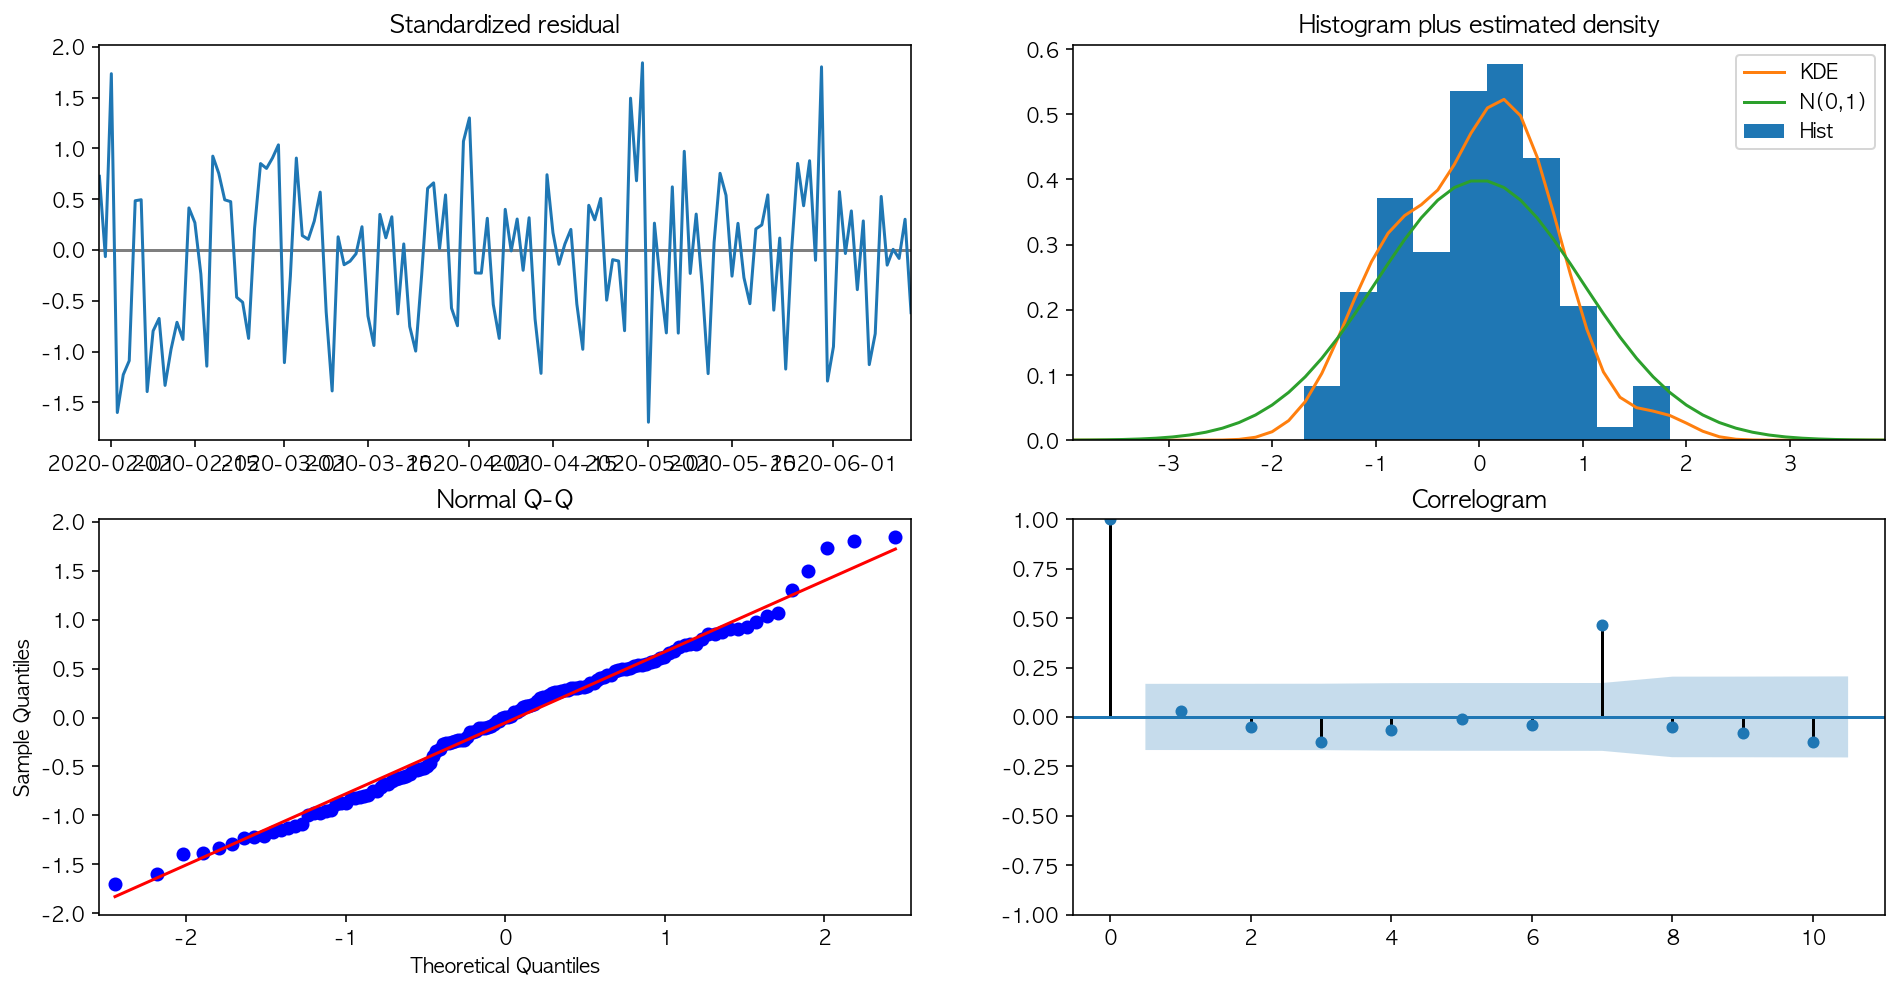

In [16]:
#약국
results.plot_diagnostics(figsize=(16, 8))
plt.show()

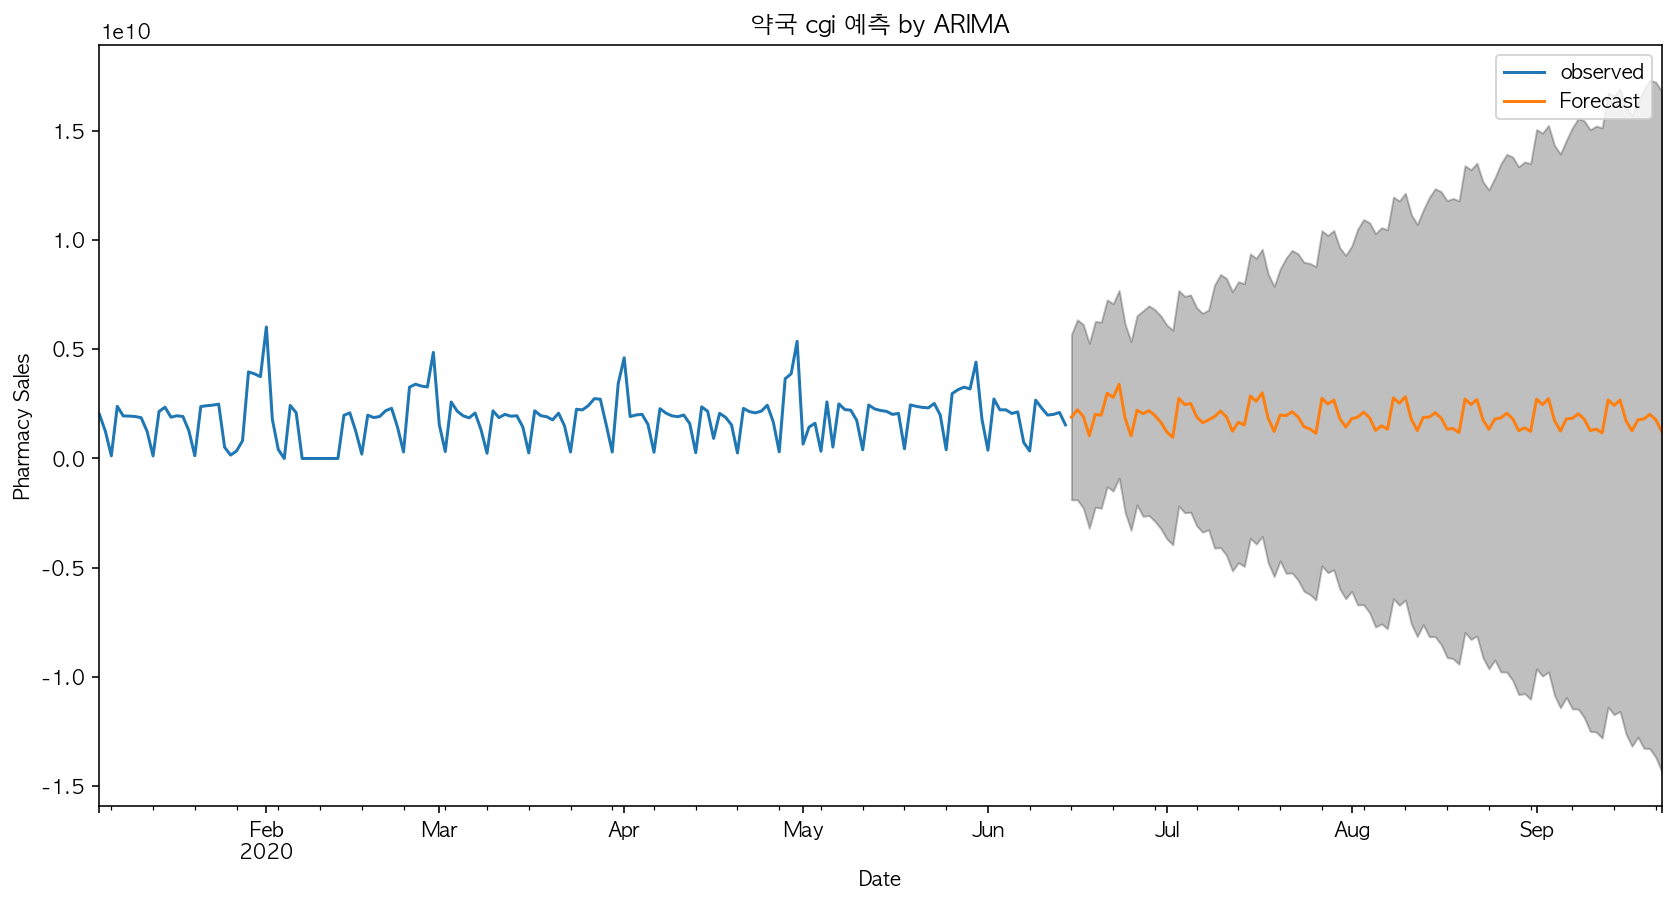

In [17]:
#y_med = 약국 ARIMA cgi 분석

pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y_med.plot(label='observed', figsize=(14, 7))
plt.title('약국 cgi 예측 by ARIMA')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Pharmacy Sales')
plt.legend()
plt.show()


# cgi 통해 유망산업 예측해보기

뉴스에서 공공연하게 언급되기도 하는 뷰티제품은 하향세를 겪고 있는 산업 중 하나입니다. 실제로 그러한지 fbprophet을 이용하여 화장품 산업뿐만 아니라, Index data에 제시된 네 개의 산업군의 cgi를 모두 예측해보고자 합니다. cgi가 100이 넘는 산업군은 성장의 가능성이 있는 산업이겠죠?


In [18]:
! pip install pystan

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [19]:
!pip install Prophet

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [20]:
!pip3 install fbprophet

In [21]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [22]:
Index= pd.read_csv("./Data_KT/index.csv")
Index

,period,catl,catm,age,gender,sido,sigungu,cgi
0,201901,건강/의료용품,건강관리용품,20,F,서울,관악구,115.374642
1,201901,건강/의료용품,건강관리용품,20,F,서울,광진구,119.596454
2,201901,건강/의료용품,건강관리용품,20,F,서울,도봉구,156.992847
3,201901,건강/의료용품,건강관리용품,20,F,서울,동작구,58.342726
4,201901,건강/의료용품,건강관리용품,20,F,서울,마포구,145.147595
...,...,...,...,...,...,...,...,...
127520,202005,화장품,화장품,all,all,서울,강서구,51.365660
127521,202005,화장품,화장품,all,all,서울,관악구,61.997865
127522,202005,화장품,화장품,all,all,서울,금천구,82.198402
127523,202005,화장품,화장품,all,all,서울,도봉구,35.875600


In [23]:
df_index = Index.set_index('catl')
df_index.index.unique()

Index(['건강/의료용품', '식품', '일용품', '화장품'], dtype='object', name='catl')

In [24]:
#각 제품군 별 cgi(소비자성장지수)의 변화량과 앞으로를 파악
#화장품
is_makeup = Index['catl'] == '화장품'
makeup = Index[is_makeup]
makeup

#건강/의료용품
health = Index['catl']== '건강/의료용품'
health = Index[health]
health

#식품
food = Index['catl']=='식품'
food = Index[food]
food

#일용품
garage = Index['catl']=='일용품'
garage = Index[garage]
garage

,period,catl,catm,age,gender,sido,sigungu,cgi
234,201901,일용품,생활용품,20,F,서울,all,103.840411
235,201901,일용품,생활용품,20,F,서울,강남구,90.263049
236,201901,일용품,생활용품,20,F,서울,구로구,107.414195
237,201901,일용품,생활용품,20,F,서울,동작구,43.055576
238,201901,일용품,생활용품,20,F,서울,서대문구,102.167173
...,...,...,...,...,...,...,...,...
127452,202005,일용품,애완동물용품,all,M,서울,종로구,45.803908
127453,202005,일용품,애완동물용품,all,all,서울,강북구,69.380899
127454,202005,일용품,애완동물용품,all,all,서울,강서구,82.460426
127455,202005,일용품,애완동물용품,all,all,서울,송파구,47.014752


In [25]:
#화장품:2

idx_2 = pd.to_datetime(makeup['period'],format='%Y%m')
lst2 = list(makeup['cgi'])
ts_makeup = Series(lst2,idx_2)
y2 = ts_makeup.resample('M').mean()

#health:3
idx_3 =  pd.to_datetime(health['period'],format='%Y%m')
lst3 = list(health['cgi'])
ts_health = Series(lst3,idx_3)
y3 = ts_health.resample('M').mean()

#식품:4

idx_4 =  pd.to_datetime(food['period'],format='%Y%m')
lst4 = list(food['cgi'])
ts_food= Series(lst4,idx_4)
y4 = ts_food.resample('M').mean()

#일용품: 5

idx_5 =  pd.to_datetime(garage['period'],format='%Y%m')
lst5 = list(garage['cgi'])
ts_garage = Series(lst5,idx_5)
y5 = ts_garage.resample('M').mean()



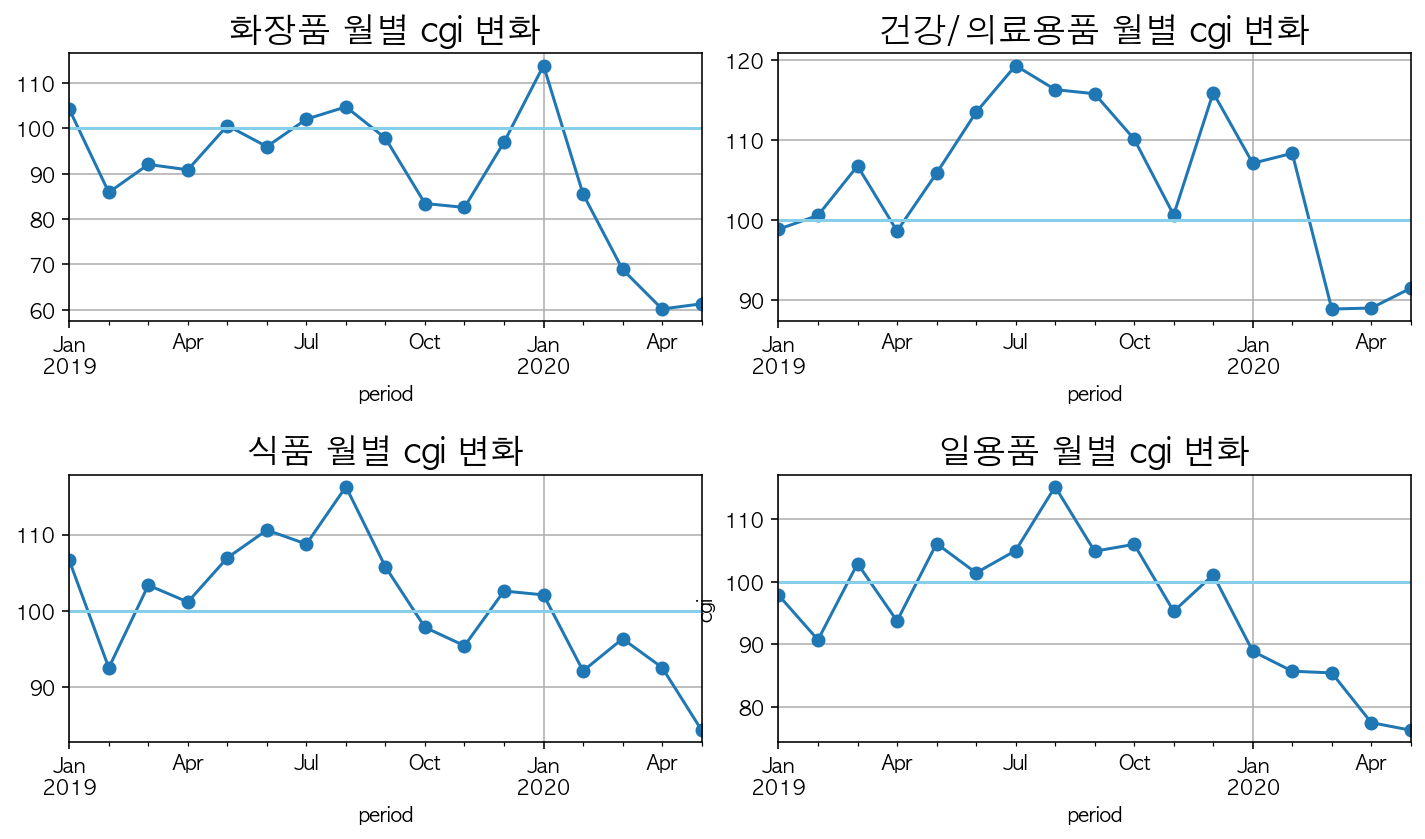

In [26]:
#각 제품군별 cgi 변화

plt.subplot(221)
y2.plot(figsize =(10,6), marker='o')
plt.axhline(y=100,color ='skyblue')
plt.title('화장품 월별 cgi 변화', fontsize=17)
plt.grid('True')


plt.subplot(222)
y3.plot(figsize =(10,6), marker='o')
plt.axhline(y=100,color ='skyblue')
plt.title('건강/의료용품 월별 cgi 변화', fontsize=17)
plt.grid('True')


plt.subplot(223)
y4.plot(figsize =(10,6), marker='o')
plt.axhline(y=100,color ='skyblue')
plt.title('식품 월별 cgi 변화', fontsize=17)
plt.grid('True')


plt.subplot(224)
y5.plot(figsize =(10,6), marker='o')
plt.axhline(y=100,color ='skyblue')
plt.title('일용품 월별 cgi 변화', fontsize=17)
plt.grid('True')

plt.tight_layout()
plt.ylabel('cgi')
plt.show()

In [27]:
df_ts_garage = pd.DataFrame()
df_ts_garage = ts_garage.to_frame()
df_ts_garage= df_ts_garage.reset_index()
df_ts_garage.columns= ['ds','y']

In [28]:
#fbprophet 모듈에 맞게 재설정
#ts = 화장품 cgi Series with datetime
#화장품
df_ts = pd.DataFrame()
df_ts = ts_makeup.to_frame()
df_ts= df_ts.reset_index()
df_ts.columns= ['ds','y']
#건강/의료용품
df_ts_health = pd.DataFrame()
df_ts_health = ts_health.to_frame()
df_ts_health = df_ts_health.reset_index()
df_ts_health.columns = ['ds','y']

#식품
df_ts_food = pd.DataFrame()
df_ts_food = ts_food.to_frame()
df_ts_food= df_ts_food.reset_index()
df_ts_food.columns= ['ds','y']


In [29]:
m = Prophet() # Default growth='linear'
m.fit(df_ts)

h = Prophet()
h.fit(df_ts_health)

f = Prophet()
f.fit(df_ts_food)

g = Prophet()
g.fit(df_ts_garage)

future_m = m.make_future_dataframe(periods=365)
future_h = h.make_future_dataframe(periods=365)
future_f = f.make_future_dataframe(periods=365)
future_g = g.make_future_dataframe(periods=365)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Applications/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonalit

In [30]:
forecast_makeup = m.predict(future_m)
forecast_makeup.tail()

forecast_health = h.predict(future_h)
forecast_health.tail()

forecast_food = f.predict(future_f)
forecast_food.tail()

forecast_garage = f.predict(future_g)
forecast_garage.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
16029,2021-04-27,53.843691,-218.914873,307.719191,-208.611623,298.492546,0.0,0.0,0.0,0.0,0.0,0.0,53.843691
16030,2021-04-28,53.751292,-209.455580,306.794515,-210.530752,299.930980,0.0,0.0,0.0,0.0,0.0,0.0,53.751292
16031,2021-04-29,53.658893,-208.872363,308.395097,-212.449881,301.359550,0.0,0.0,0.0,0.0,0.0,0.0,53.658893
16032,2021-04-30,53.566494,-220.548108,314.226675,-214.369010,302.169719,0.0,0.0,0.0,0.0,0.0,0.0,53.566494
16033,2021-05-01,53.474096,-218.688508,314.322878,-216.305415,302.814271,0.0,0.0,0.0,0.0,0.0,0.0,53.474096


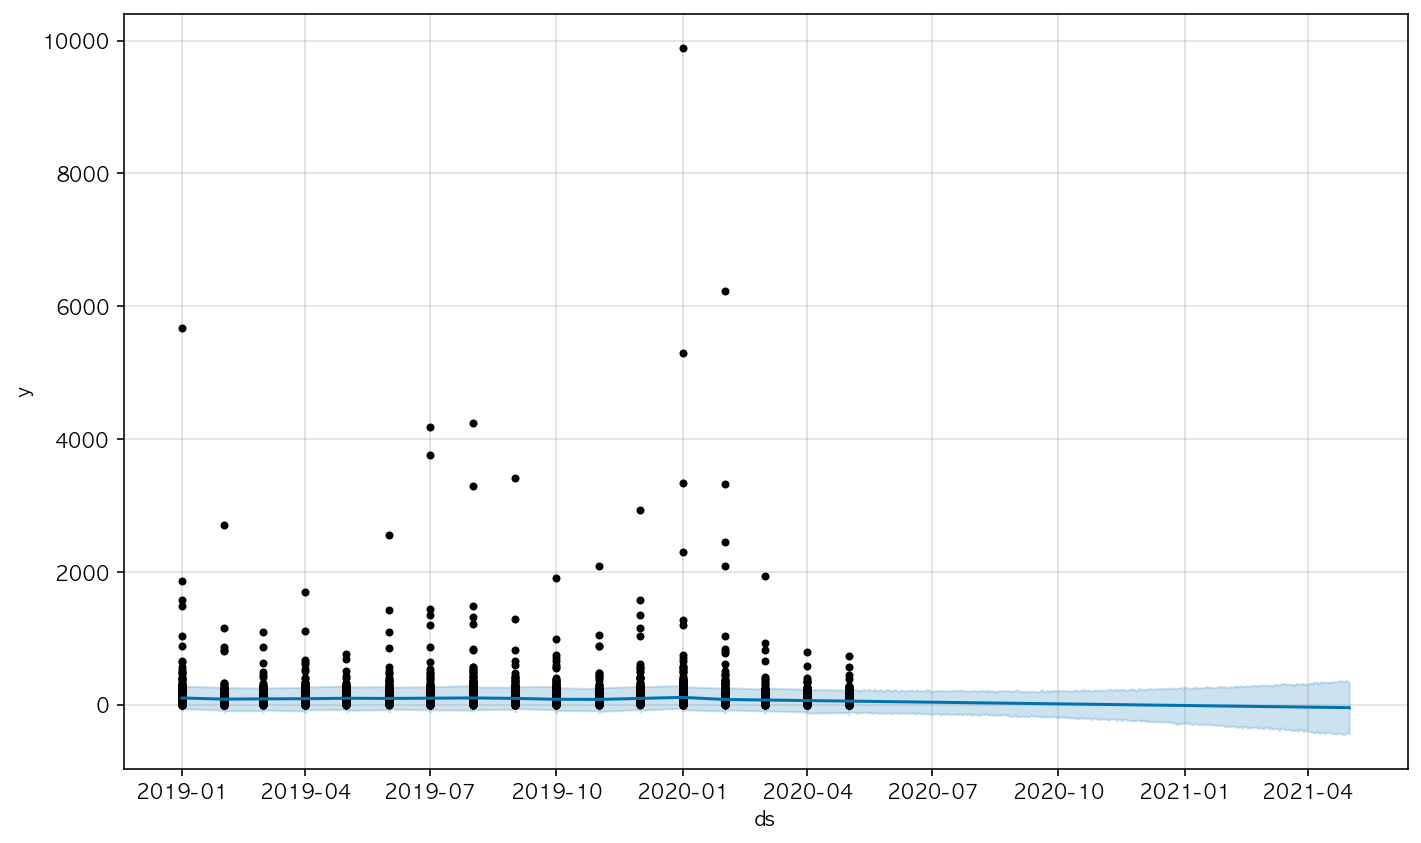

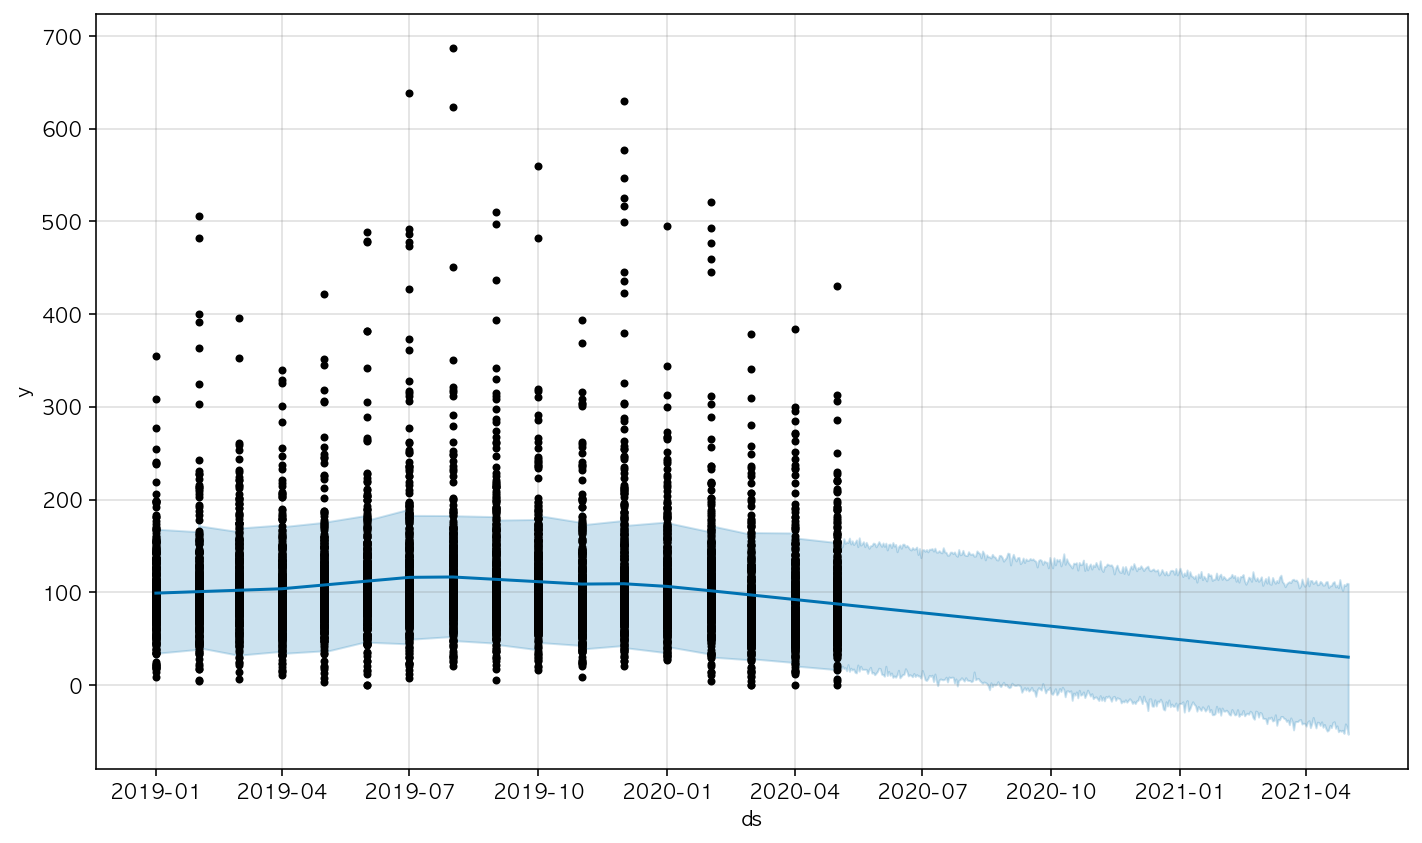

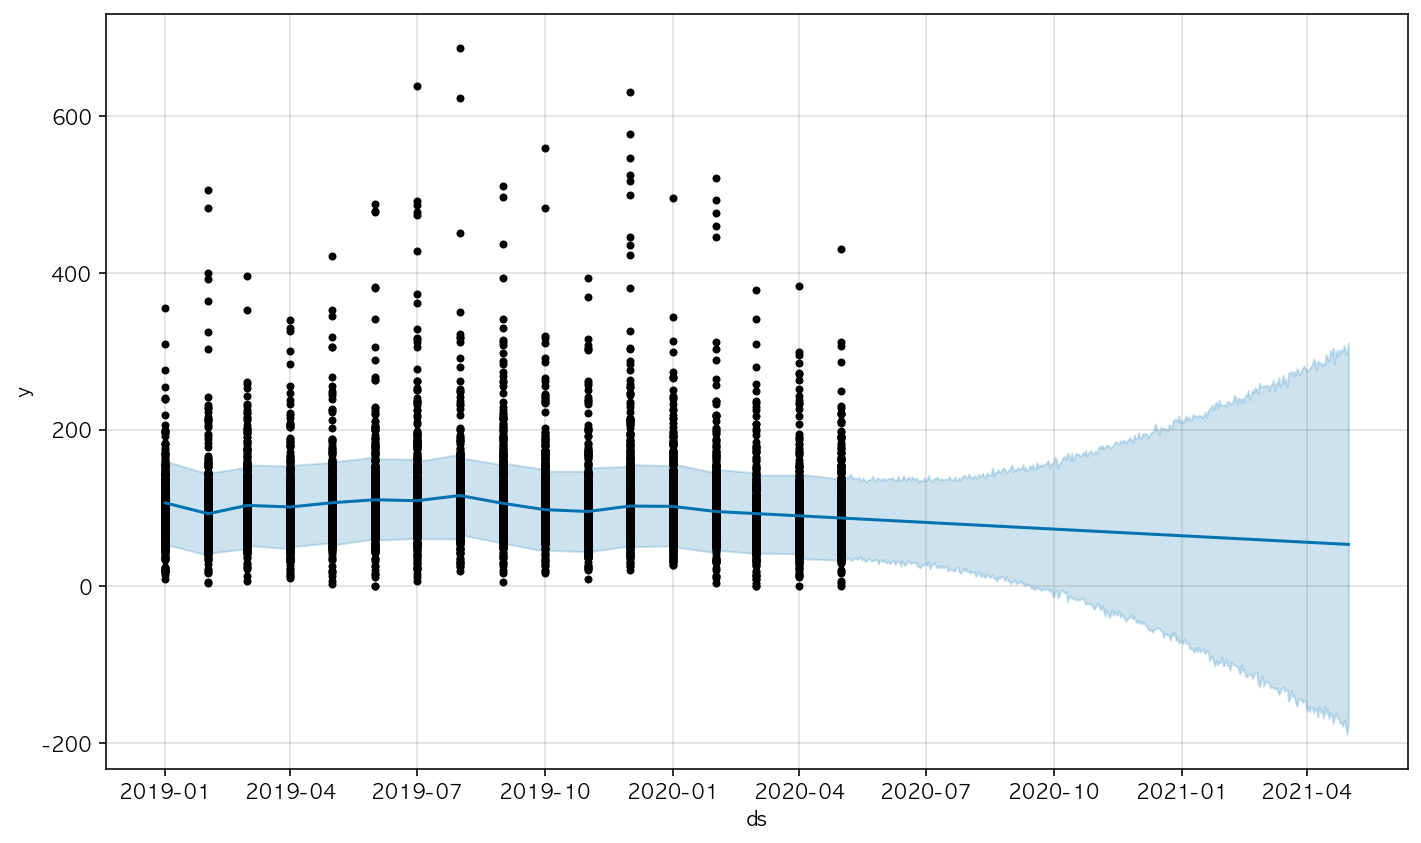

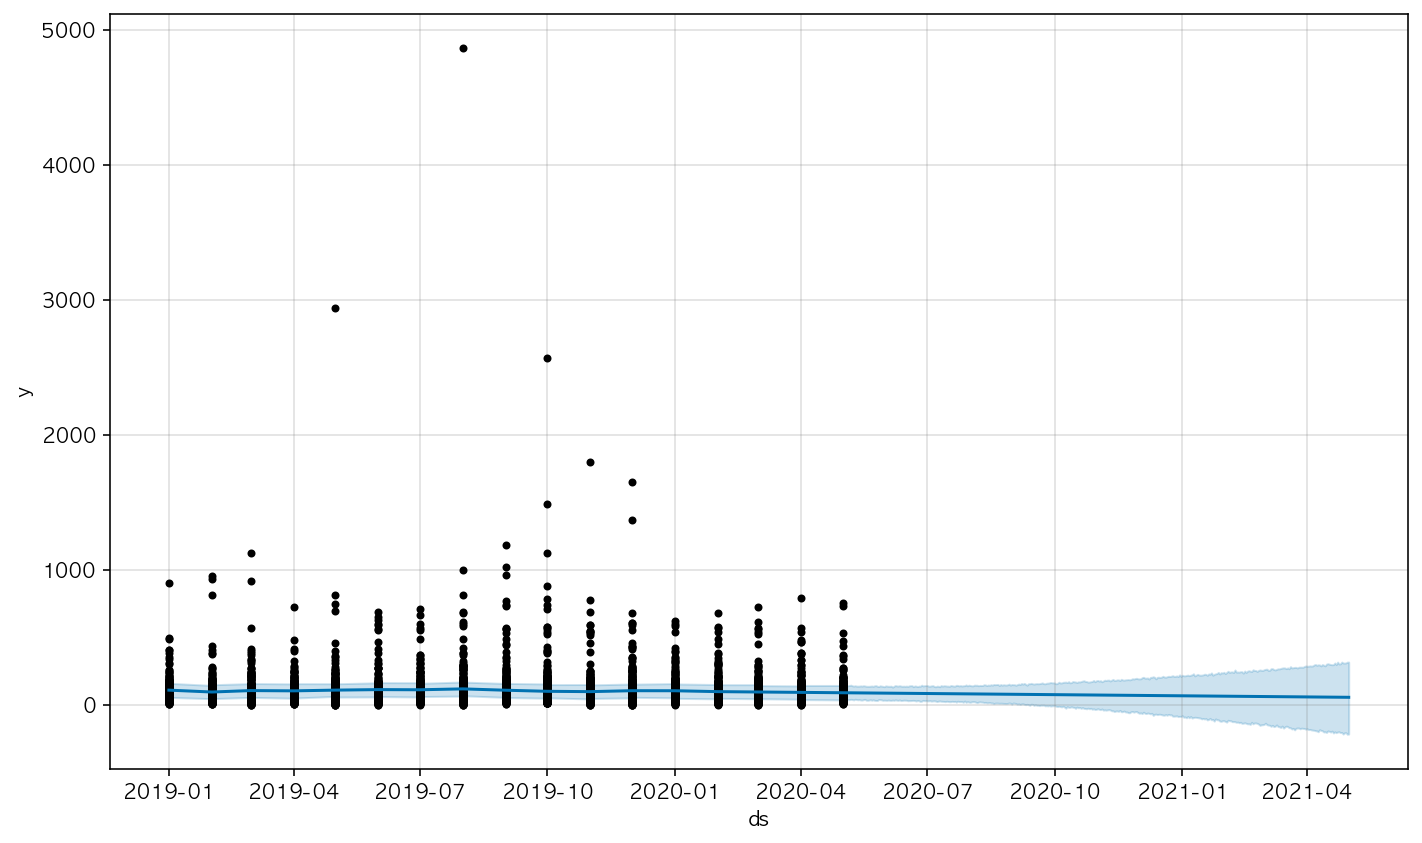

In [31]:
fig2 = m.plot(forecast_makeup)
fig3 = h.plot(forecast_health)
fig4 = h.plot(forecast_food)
fig5 = g.plot(forecast_garage)

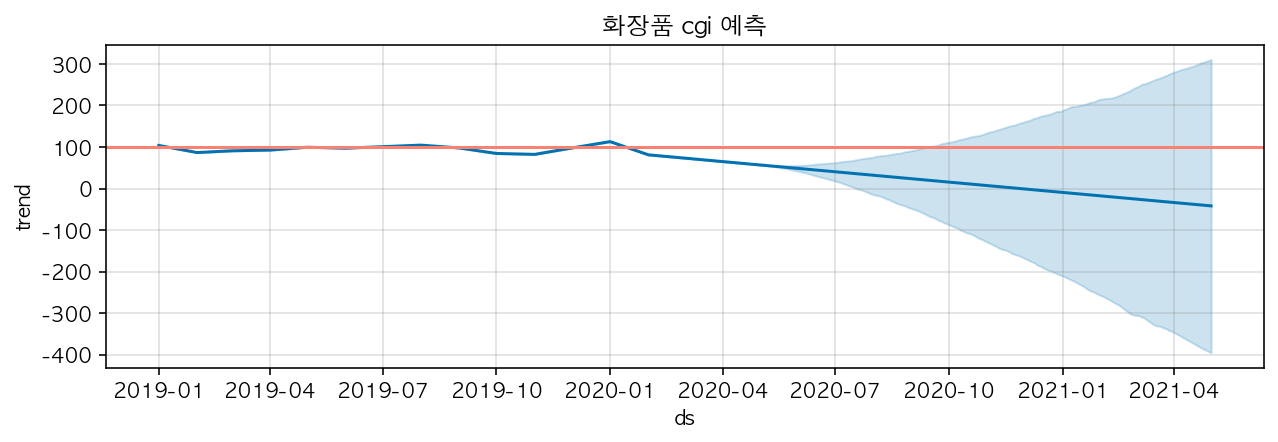

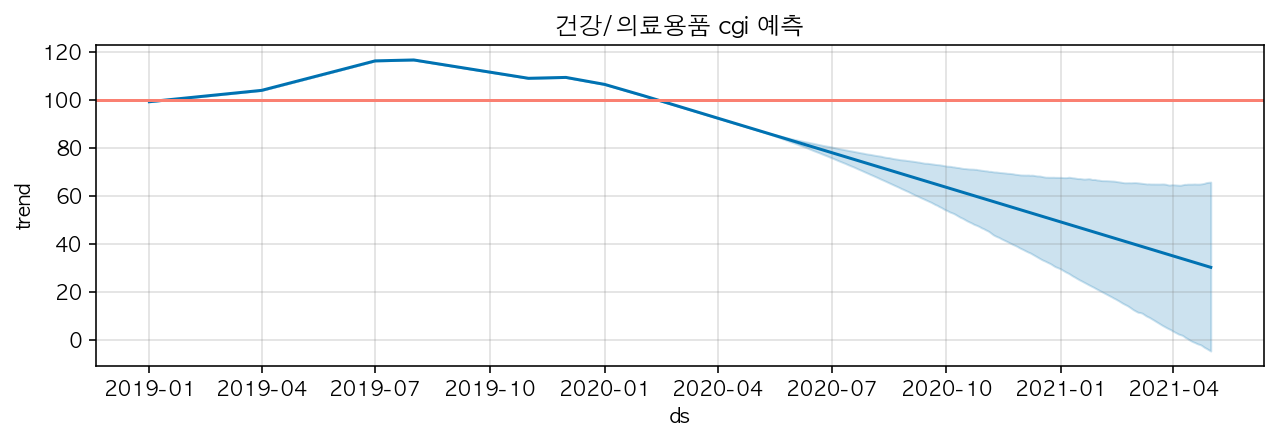

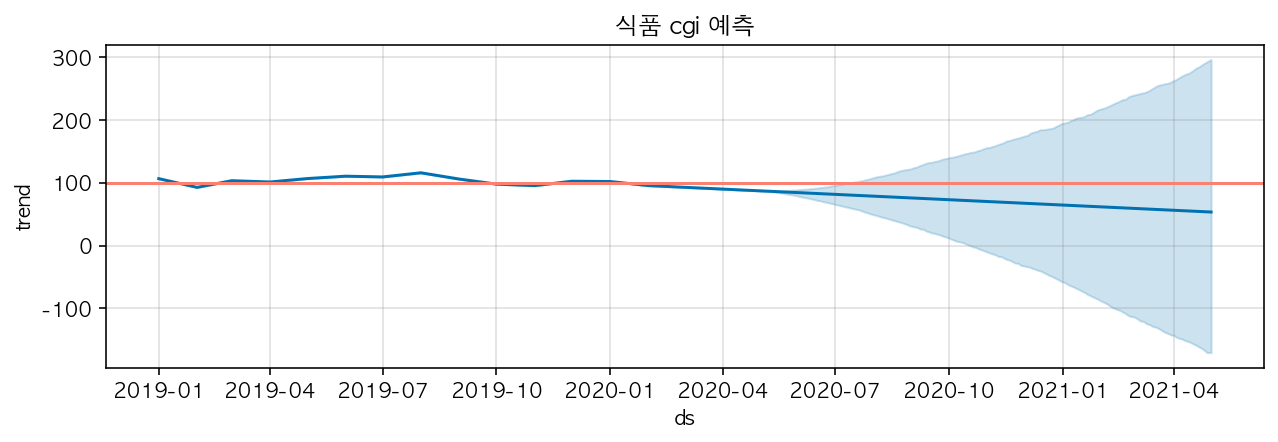

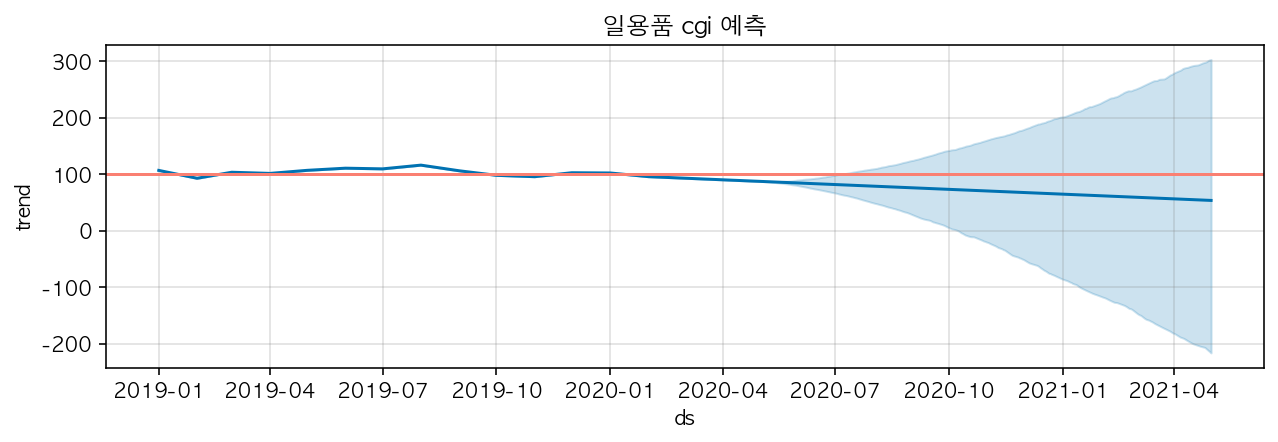

In [32]:
fig2_makeup = m.plot_components(forecast_makeup)
plt.title('화장품 cgi 예측')
plt.axhline(y=100,color ='salmon')
plt.show()

fig3_health = h.plot_components(forecast_health)
plt.title('건강/의료용품 cgi 예측')
plt.axhline(y=100,color ='salmon')
plt.show()

fig4_food = f.plot_components(forecast_food)
plt.title('식품 cgi 예측')
plt.axhline(y=100,color ='salmon')
plt.show()

fig5_garage= g.plot_components(forecast_garage)
plt.title('일용품 cgi 예측')
plt.axhline(y=100,color ='salmon')
plt.show()

즉, 코로나가 장기화 되었을 시 지금과 같은 상황에서는 모든 제품군의 소비자성장지수가 100이하로 떨어질 것으로 보입니다. 